In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

from networkx.drawing.nx_agraph import graphviz_layout#, to_agraph #, from_agraph

import seaborn as sb
sb.set_context('paper')

In [2]:
def create_graph_from_interactions(filename, sheet, source, target):
    protein_interactions = pd.read_excel(filename, sheet_name=sheet)
    G = nx.from_pandas_edgelist(protein_interactions, source, target)
    return G

def draw_net(G, ax=None, labels=True):
    if ax==None :
        ax = plt.gca()

    # pos = nx.spring_layout(G)
    pos = graphviz_layout(G) #

    params = {
        # 'with_labels': True,
        'node_color': 'silver',
        'edge_color': 'silver',
        'font_color': 'k',
        'edgecolors' : 'k',
        'node_size' : 150,
        # 'node_shape' : 's',
        'bbox' : dict(facecolor="mediumseagreen", edgecolor='black', boxstyle='round, pad=0.2', alpha=1)
    }
    nx.draw_networkx_nodes(G, ax=ax, pos=pos, **params)
    nx.draw_networkx_edges(G, ax=ax, pos=pos, **params)
    
    if labels:
        nx.draw_networkx_labels(G, ax=ax, pos=pos, **params)

    # plt.show()
    return ax
    
def net_info(G) :
    return f"{len(G)} nodes and {len(G.edges)} edges"


### Create graph from Y2H interactions

39 nodes and 150 edges


<AxesSubplot:>

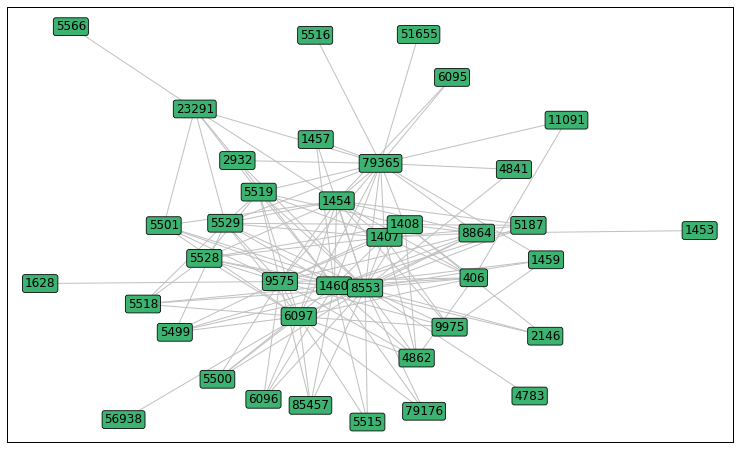

In [3]:
G_Y2H = create_graph_from_interactions(
    filename="../data/publications/journal.pgen.1003398.s008.xlsx",
    sheet="PPIs from Y2H screen Fig1B,C",
    source="Entrez gene ID A human",
    target="Entrez gene ID B human")

print(net_info(G_Y2H))
fig = plt.figure(figsize=(13, 8))
draw_net(G_Y2H)

### Create graph from UniHI MAN interactions

30 nodes and 62 edges


<AxesSubplot:>

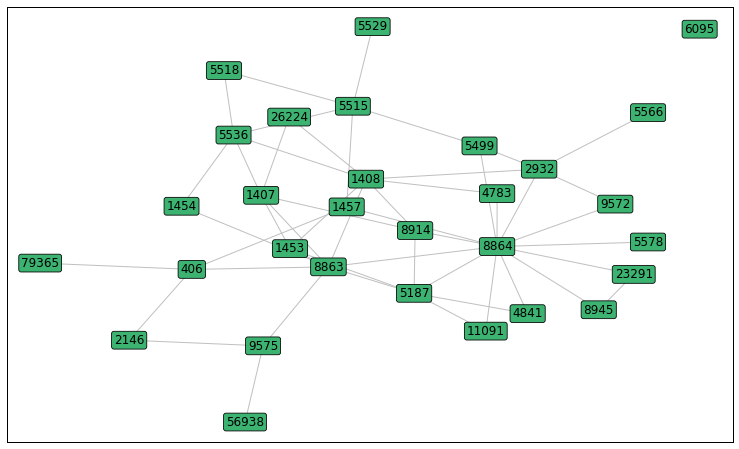

In [4]:
G_unihi_man = create_graph_from_interactions(
    filename="../data/publications/journal.pgen.1003398.s008.xlsx",
    sheet="Enrichment UniHI MAN Fig2",
    source="Entrez gene ID A human",
    target="Entrez gene ID B human")

print(net_info(G_unihi_man))
fig = plt.figure(figsize=(13, 8))
draw_net(G_unihi_man)

### Create graph from extended interactions

123 nodes and 412 edges


<AxesSubplot:>

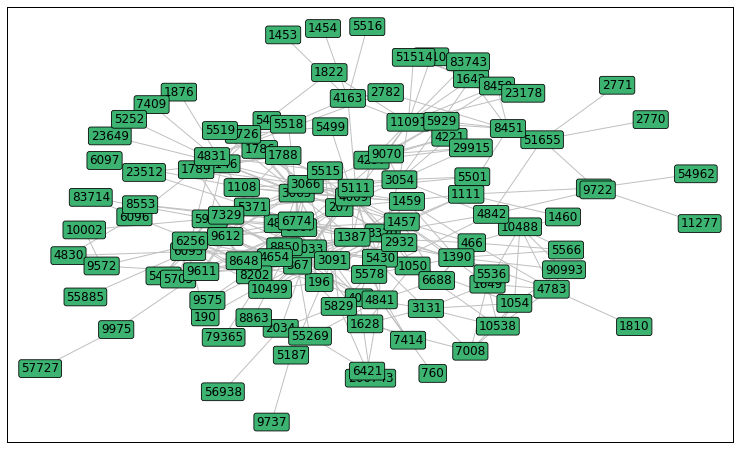

In [5]:
G_extension = create_graph_from_interactions(
    filename="../data/publications/journal.pgen.1003398.s008.xlsx",
    sheet="Extension interactions Fig2",
    source="Entrez gene ID A",
    target="Entrez gene ID B")

print(net_info(G_extension))
fig = plt.figure(figsize=(13, 8))
draw_net(G_extension)


### Combine the three networks together

In [6]:
G_1 = G_Y2H
G_2 = nx.compose(G_1, G_unihi_man)
G_3 = nx.compose(G_2, G_extension)

print(net_info(G_3))
# paper says 134 proteins with 625 interactions

134 nodes and 624 edges


### Highlight the nodes that come from the core Y2H interactions

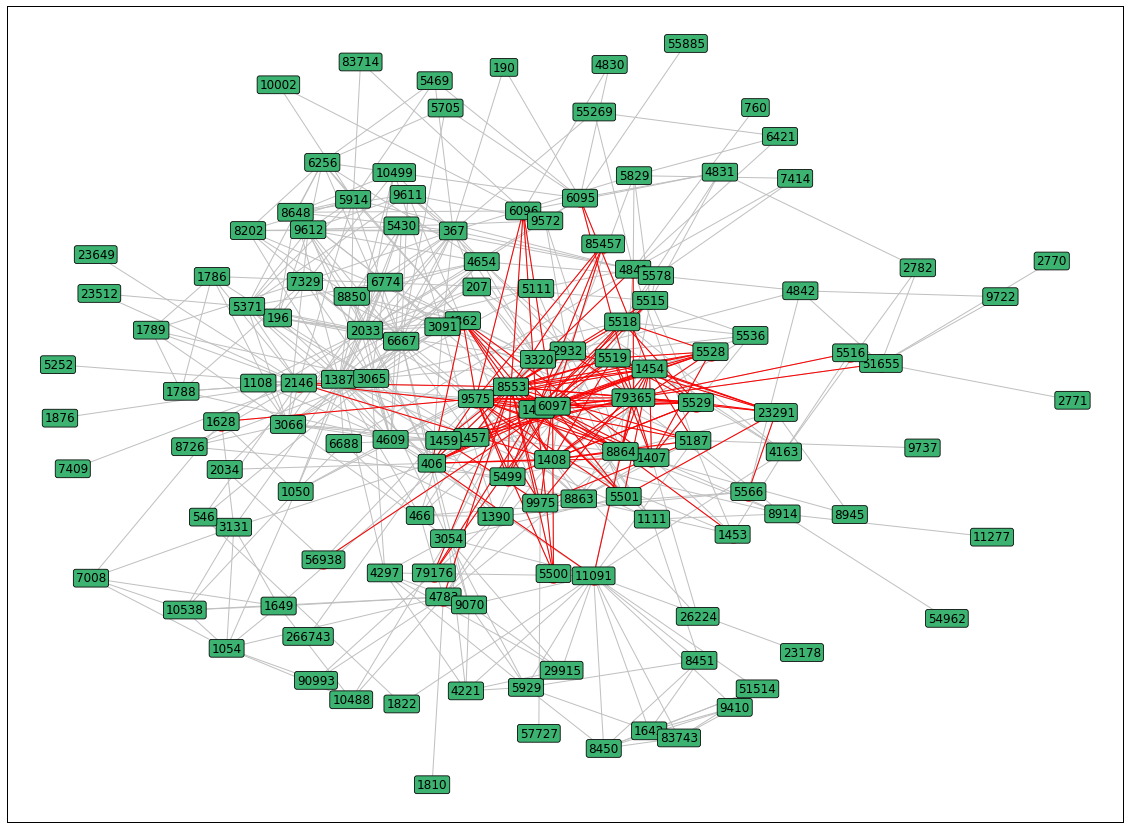

In [14]:
fig, ax = plt.subplots(figsize=(20, 15))
draw_net(G_3, labels=True, ax=ax)
pos = graphviz_layout(G_3) #

nx.draw_networkx_nodes(G_Y2H, pos=pos, ax=ax, node_color='red')
nx.draw_networkx_edges(G_Y2H, pos=pos, ax=ax, edge_color='red')

# Save edge list to a file
nx.write_edgelist(G_3, "../data/static_networks/circadian_net.edgelist")

plt.show()


### Combine the two lists of expected proteins

In [8]:
proteins_core = pd.read_excel("../data/publications/journal.pgen.1003398.s008.xlsx", sheet_name="46 circadian components Fig1")
proteins_core = proteins_core.iloc[:, 0:4]
proteins_core.columns = ['entrez_human', 'entrez_mouse', 'symbol_human', 'symbol_mouse']

proteins_extension = pd.read_excel("../data/publications/journal.pgen.1003398.s008.xlsx", sheet_name="Extension proteins Fig2")
proteins_extension = proteins_extension.iloc[:, 1:5]
proteins_extension.columns = ['entrez_human', 'entrez_mouse', 'symbol_human', 'symbol_mouse']

proteins = pd.concat([proteins_core, proteins_extension], ignore_index=True) # 134 unique proteins
expected_proteins = list(proteins['entrez_human'].values)

### For every protein that's actually involved in an interaction, add data from the 'expected proteins' table

In [9]:
interacting_proteins = pd.DataFrame(G_3.nodes)
interacting_proteins.columns = ['entrez_human']
interacting_proteins = interacting_proteins.merge(proteins, how='left', left_on='entrez_human', right_on='entrez_human')

### Check all expected proteins were involved in a reaction, and vice versa

In [10]:
proteins_not_in_any_interaction = [
    protein
    for protein
    in expected_proteins
    if protein not in G_3.nodes
]

unexpected_interacting_proteins = [
    interacting_protein
    for interacting_protein
    in G_3.nodes
    if interacting_protein not in expected_proteins
]

print(sorted(unexpected_interacting_proteins))
print(sorted(proteins_not_in_any_interaction))

[]
[]


### Merge Affy IDs with Entrez IDs

In [11]:
temporal_node_data = pd.read_csv('../data/temporal_data/GSE11923_series_matrix.txt', sep='\t', header=63, index_col=0, skipfooter=1, engine='python')
affy_to_entrez = pd.read_csv('../data/gene_ID_conversion/DAVID_affy_to_entrez.txt', sep='\t', index_col=0)

temporal_node_data = temporal_node_data.merge(affy_to_entrez['entrez'], how='left', left_index=True, right_index=True)
temporal_node_data['affy'] = temporal_node_data.index

temporal_node_data = interacting_proteins.merge(temporal_node_data, how='left', left_on='entrez_mouse', right_on='entrez')

columns = list(temporal_node_data.columns.values)
columns = [columns[-1]] + [columns[1], columns[0]] + [columns[3], columns[2]] + columns[4:-2]
temporal_node_data = temporal_node_data[columns]
columns = columns[0:5] + [i+1 for i, _ in enumerate(columns[5:])]
temporal_node_data.columns = columns
temporal_node_data.sort_values('entrez_mouse', inplace=True)

### Create a table of temporal node data

IMPORTANT: The Affy IDs don't match uniquely to Entrez IDs, so in lots of cases a single Entrez ID can correspond to
several sets of temporal data.

In [12]:
temporal_node_data_mean = pd.DataFrame()
temporal_node_data_mean_normalised = pd.DataFrame()

for entrez_human in G_3.nodes:
    affy_proteins = temporal_node_data.loc[temporal_node_data['entrez_human'] == entrez_human]
    series = affy_proteins[affy_proteins.columns[5:]].T
    mean = series.apply(lambda row: row.mean(), axis=1)
    temporal_node_data_mean[entrez_human] = mean
    temporal_node_data_mean_normalised[entrez_human] = mean / mean.max()

temporal_node_data_mean.to_csv('../data/temporal_data/temporal_node_data_mean.csv', sep='\t')
temporal_node_data_mean_normalised.to_csv('../data/temporal_data/temporal_node_data_mean_normalised.csv', sep='\t')

### Graph all of the temporal data for each Entrez ID.

In [13]:
# # Plot temporal data for each Affymetrix ID for each protein, as well as mean and normalised versions of this plot.
# for entrez_human in G_3.nodes:
#     affy_proteins = temporal_node_data.loc[temporal_node_data['entrez_human'] == entrez_human]
#     series = affy_proteins[affy_proteins.columns[5:]].T
#     mean = series.apply(lambda row: row.mean(), axis=1)
#     normalised = series.copy()
#     for column in list(normalised.columns):
#         normalised[column] = normalised[column] / normalised[column].max()
#
#     symbol = affy_proteins["symbol_mouse"].values[0]
#     affy_ids = list(affy_proteins['affy'].values)
#     fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 3*3))
#
#     series.plot(ax=ax1)
#     ax1.legend(affy_ids)
#     ax1.set_title(f'{symbol} Actual')
#
#     mean.plot(ax=ax2, legend=False)
#     ax2.set_title(f'{symbol} Mean')
#
#     normalised.plot(ax=ax3)
#     ax3.legend(affy_ids)
#     ax3.set_title(f'{symbol} Normalised')
#
#     fig.tight_layout()
#     fig.savefig(f'../data/output/temporal_graphs/{symbol}.png')
